 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py: 16

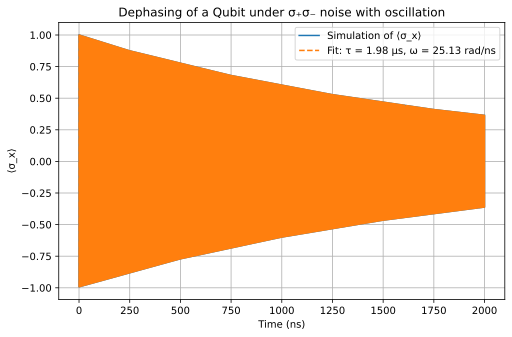

Decay time: 1980.20 ns
Oscillation frequency: 25.1327 rad/ns
1/T2 = 0.000505 ns⁻¹
γ_relax/2 (relaxation rate) = 0.000500 ns⁻¹
γ/2 (dephasing rate) = 0.000005 ns⁻¹


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# Set parameters
sigma_p = sigmap()
sigma_m = sigmam()
noise = sigma_p * sigma_m  # Using σ₊σ₋ as the noise operator
gamma = 1/1e5
gamma_relax = 1/1000
t_list = np.linspace(0, 2000, 50000)  # Time points for simulation (up to 2000 ns)
initial_state = (basis(2, 0) + basis(2, 1)).unit()  # |+> state
sigma_x = sigmax()

# Hamiltonian
H0 = 4 * 2 * np.pi * sigma_p * sigma_m
H = [H0]

# Lindblad collapse operator
L =  np.sqrt(gamma) * sigma_p * sigma_m
L_relax = np.sqrt(gamma_relax) * sigma_p * sigma_m
c_ops = [L, L_relax]

# Time evolution using mesolve
result = mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    e_ops=[sigma_x],
    options=Options(rtol=1e-14, atol=1e-14)
)

# Expectation value of σ_x
avg_sigma_x = result.expect[0]

# Exponential decay with oscillation fit
from scipy.optimize import curve_fit

def exp_decay_with_oscillation(t, tau, w):
    return np.exp(-t / tau) * np.cos(w * t)

initial_guess = [2/gamma, 4*2*np.pi]
params, covariance = curve_fit(exp_decay_with_oscillation, t_list, avg_sigma_x, p0=initial_guess)
tau, w = params

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(t_list, avg_sigma_x, label="Simulation of ⟨σ_x⟩")
plt.plot(
    t_list,
    exp_decay_with_oscillation(t_list, *params),
    label=f"Fit: τ = {tau/1000:.2f} μs, ω = {w:.2f} rad/ns",
    linestyle="--"
)
plt.xlabel("Time (ns)")
plt.ylabel("⟨σ_x⟩")
plt.title("Dephasing of a Qubit under σ₊σ₋ noise with oscillation")
plt.legend()
plt.grid(True)
plt.show()

# Return fitted parameters
print(f"Decay time: {tau:.2f} ns")
print(f"Oscillation frequency: {w:.4f} rad/ns")

# Calculate and print rates
T2 = tau  # T2 is the fitted decay time
print(f"1/T2 = {1/T2:.6f} ns⁻¹")
print(f"γ_relax/2 (relaxation rate) = {gamma_relax/2:.6f} ns⁻¹")
print(f"γ/2 (dephasing rate) = {gamma/2:.6f} ns⁻¹")




np.float64(1981.13764941092)

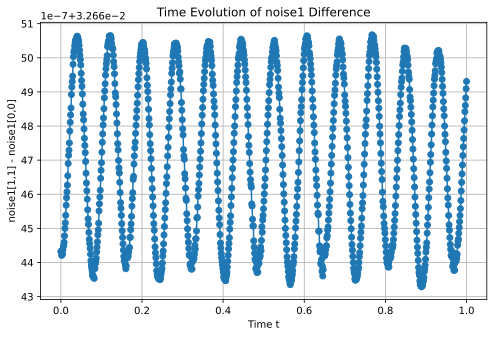

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonian_generator import Hamiltonian
import qutip as qt

# Set parameters based on the system from file_context_0
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
# Use a specific A value from the range used in the analysis
A = 5e-3 * 2 * np.pi  # Example A value
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Set up the Floquet system
initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
# Create an array of time values to sample 
t_values = np.linspace(0, 1, 1000)
diff_vals = []

for t in t_values:
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    # Work with a fresh copy of noise every time
    noise = sc.s.copy()
    np.fill_diagonal(noise, np.diag(noise) - noise[0,0])
    noise1 = Ud @ noise @ U
    # Take the real part if necessary
    # diff_vals.append(noise1[1,1] - noise1[0,0])
    diff_vals.append(noise1[3,1])

plt.figure(figsize=(8,5))
plt.plot(t_values, np.abs(diff_vals), marker='o', linestyle='-')
plt.xlabel("Time t")
plt.ylabel("noise1[1,1] - noise1[0,0]")
plt.title("Time Evolution of noise1 Difference")
plt.grid(True)
plt.show()

In [3]:
from hamiltonian_generator import Hamiltonian
import qutip as qt


phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,4])

# Create array of A values from 1e-3*2*np.pi to 5*1e-3*2*np.pi with 20 points
A_values = np.linspace(1e-4 * 2 * np.pi, 5e-3 * 2 * np.pi, 20)
all_diff_vals = []

from joblib import Parallel, delayed

def process_A_value(A, sc):
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,4])
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
    sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
    initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    
    t = 0
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    # Work with a fresh copy of noise every time
    noise1 = Ud @ sc.s @ U
    # Take the real part if necessary
    
    
    return noise1, optimal_omega

all_diff_vals, optimal_omegas = zip(*Parallel(n_jobs=-1)(delayed(process_A_value)(A, sc) for A in A_values))



In [4]:
# Store the whole matrix for each noise operator
noise_matrices = []
for noise1 in all_diff_vals:
    # For each matrix, subtract the [0,0] element from all diagonal terms
    modified_matrix = noise1.copy()
    diag_indices = np.diag_indices_from(modified_matrix)
    modified_matrix[diag_indices] = modified_matrix[diag_indices] - noise1[0,0]
    noise_matrices.append(modified_matrix)

noise_matrices = np.array(noise_matrices)

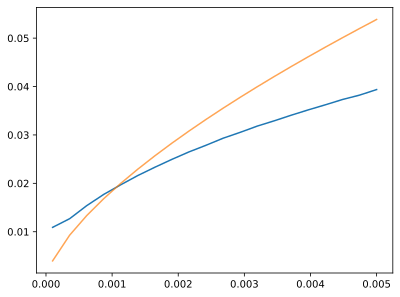

In [5]:
plt.plot(A_values/(2*np.pi),np.abs(noise_matrices[:,2,0]))
# plt.plot(A_values/(2*np.pi),np.abs(noise_matrices[:,3,1]))
# plt.plot(A_values/(2*np.pi),np.abs(noise_matrices[:,4,0])-0.01)
plt.plot(A_values/(2*np.pi), (2*A_values/(0.1*2*np.pi))**(2/3)/4, alpha=0.7, label='(A/(0.1*2π))^(1/3)')



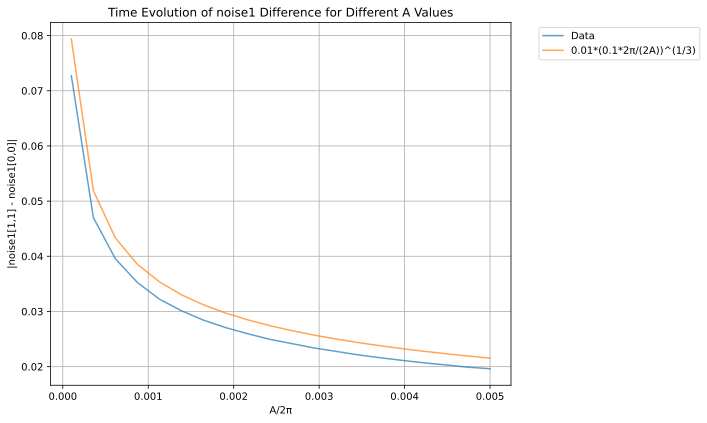

In [6]:
### when system is decoupled, this is expected to be 0, only sigmaz will show up
##$ when drive is on, and if it is strong compaed to dispersive coupling, then we also expect only sigmaz will show up. when drive is weakened, effect of dispersive coupling starts showing up,
### where term like sigmaz c^dagger c, sigmaz (c^dagger c)^2 will show up.
# Plot results for all A values
plt.figure(figsize=(10, 6))
plt.plot(A_values/(2*np.pi), np.abs(noise_matrices[:,1,1]),  alpha=0.7, label='Data')
plt.plot(A_values/(2*np.pi), 0.01*(0.1*2*np.pi/(2*A_values))**(1/3), alpha=0.7, label='0.01*(0.1*2π/(2A))^(1/3)')

plt.xlabel("A/2π")
plt.ylabel("|noise1[1,1] - noise1[0,0]|")
plt.title("Time Evolution of noise1 Difference for Different A Values")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonian_generator import Hamiltonian
import qutip as qt

# Set parameters based on the system from file_context_0
phi_ex = 0.2
Ej = 30.19 
Ec = 0.1
sc = Hamiltonian(phi_ex, Ej, Ec, [5,3])
# Use a specific A value from the range used in the analysis
A = 5e-3 * 2 * np.pi  # Example A value
optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi

sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
H0 = qt.Qobj(sc.H)
H_control = qt.Qobj(sc.H_control)
# Set up the Floquet system
initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)

# Get the noise operator from the system
t = 0
U, _, _ = state_and_sigmax(t)
Ud = U.T.conj()
U,_,_ = state_and_sigmax(0)
initial_state = qt.Qobj(U[:,1])


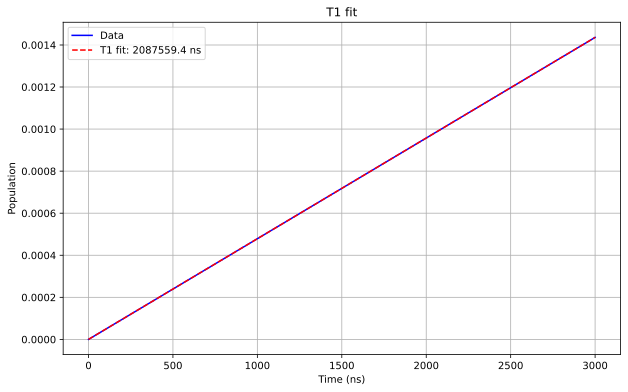

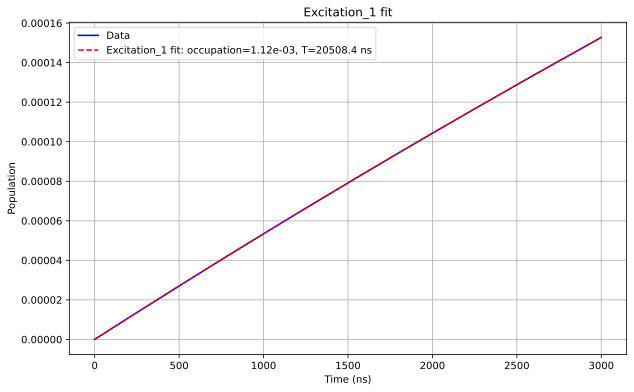

In [59]:


# Parameters for time evolution
gamma = 1/20000
t_list = np.linspace(0, 3000, 10000)  # Time points for simulation (up to 2000 ns)

# Use the system's Hamiltonian
H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

# Create collapse operators using the system's noise operator
L = np.sqrt(gamma) * qt.Qobj(sc.s)
c_ops = [L]

# Time evolution using mesolve
result = qt.mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    options=qt.Options(rtol=1e-10, atol=1e-10)
)

dims = H0.full().shape[0]
avg_values = np.zeros((dims+1, len(t_list)))
for i, t in enumerate(t_list):
    # Get the state at time t
    state_t = result.states[i]
    
    # Get the projector at time t
    U, sigmaxc,_ = state_and_sigmax(t)
    projectors = get_projector(U)
    
    # Calculate expectation values for all projectors
    for j in range(dims):
        avg_values[j, i] = qt.expect(projectors[j], state_t)
    avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

# Fit exponential decay to extract relaxation time
from scipy.optimize import curve_fit

def relaxation_fit(t,  T1):
    return  1 - np.exp(-t / T1)


# Initial guess for parameters
p0 = [1000]  # occupation and steady_time guess
# Fit the data
popt, pcov = curve_fit(relaxation_fit, t_list, avg_values[0] , p0=p0)
T1 = popt[0]

# Plot the T1 fit
plt.figure(figsize=(10, 6))
plt.plot(t_list, avg_values[0], 'b-', label='Data')
plt.plot(t_list, relaxation_fit(t_list, T1), 'r--', label=f'T1 fit: {T1:.1f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('T1 fit')
plt.legend()
plt.grid(True)
plt.show()


def steady_state_fit(t, occupation, steady_time):
    return occupation *(1 -  np.exp(-t / steady_time))
# Initial guess for parameters
p0 = [1e-3, 1000]  # occupation and steady_time guess
# Fit the data
popt, pcov = curve_fit(steady_state_fit, t_list, avg_values[3] , p0=p0)
occupation_1 = popt[0]
steady_time_1 = popt[1]

# Plot the excitation_1 fit
plt.figure(figsize=(10, 6))
plt.plot(t_list, avg_values[3], 'b-', label='Data')
plt.plot(t_list, steady_state_fit(t_list, occupation_1, steady_time_1), 'r--', label=f'Excitation_1 fit: occupation={occupation_1:.2e}, T={steady_time_1:.1f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Excitation_1 fit')
plt.legend()
plt.grid(True)
plt.show()





 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py: 16

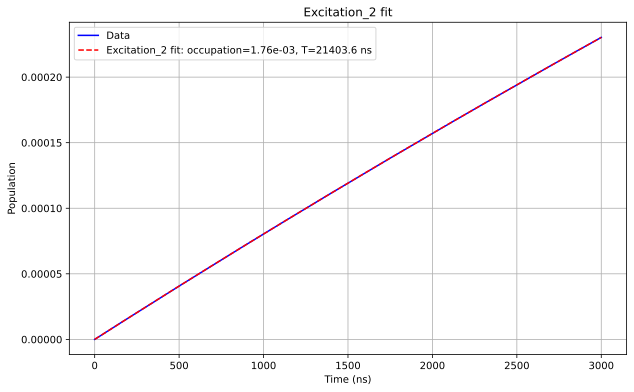

In [60]:
# Get the noise operator from the system
t = 0
U, _, _ = state_and_sigmax(t)
Ud = U.T.conj()
U,_,_ = state_and_sigmax(0)
initial_state = qt.Qobj(U[:,0])

# Use the system's Hamiltonian
H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

# Create collapse operators using the system's noise operator
L = np.sqrt(gamma) * qt.Qobj(sc.s)
c_ops = [L]

# Time evolution using mesolve
result = qt.mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    options=qt.Options(rtol=1e-10, atol=1e-10)
)

avg_values = np.zeros((dims+1, len(t_list)))
for i, t in enumerate(t_list):
    # Get the state at time t
    state_t = result.states[i]
    
    # Get the projector at time t
    U, sigmaxc,_ = state_and_sigmax(t)
    projectors = get_projector(U)
    
    # Calculate expectation values for all projectors
    for j in range(dims):
        avg_values[j, i] = qt.expect(projectors[j], state_t)
    avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

# Initial guess for parameters
p0 = [1e-3, 1000]  # occupation and steady_time guess

# Fit the data
popt, pcov = curve_fit(steady_state_fit, t_list, avg_values[2], p0=p0)
occupation_0 = popt[0]
steady_time_0 = popt[1]

# Plot the excitation_2 fit
plt.figure(figsize=(10, 6))
plt.plot(t_list, avg_values[2], 'b-', label='Data')
plt.plot(t_list, steady_state_fit(t_list, occupation_0, steady_time_0), 'r--', label=f'Excitation_2 fit: occupation={occupation_0:.2e}, T={steady_time_0:.1f} ns')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.title('Excitation_2 fit')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from hamiltonian_generator import Hamiltonian
import qutip as qt

initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)

initial_state = qt.Qobj(initial_state)

# Parameters for time evolution
gamma = 1/2e4
t_list = np.linspace(0, 3, 200)  # Time points for simulation (up to 2000 ns)
options = qt.Options(rtol=1e-14, atol=1e-14)
# Use the system's Hamiltonian
H = [H0, [H_control, lambda t, args: A * np.cos(optimal_omega * t)]]  # Time-dependent Hamiltonian

# Create collapse operators using the system's noise operator
L = np.sqrt(gamma) * qt.Qobj(sc.s)
c_ops = [L]

# Time evolution using mesolve
result = qt.mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    options=options
)

dims = H0.full().shape[0]
avg_values = np.zeros((dims+1, len(t_list)))
for i, t in enumerate(t_list):
    # Get the state at time t
    state_t = result.states[i]
    
    # Get the projector at time t
    U, sigmaxc,_ = state_and_sigmax(t)
    projectors = get_projector(U)
    
    # Calculate expectation values for all projectors
    for j in range(dims):
        avg_values[j, i] = qt.expect(projectors[j], state_t)
    avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

# Fit to cosine function
def cos_fit(t, omega):
    return np.cos(omega * t)

# Fit the data
from scipy.optimize import curve_fit

# Initial guess for parameters
p0 = [sc.fit_omega]  # frequency guess

# Fit the data
popt, pcov = curve_fit(cos_fit, t_list, avg_values[-1], p0=p0)
omega_fit = popt[0]

t_list = np.linspace(0, 10000, 20000)  # Time points for simulation (up to 2000 ns)
# Time evolution using mesolve
result = qt.mesolve(
    H,
    initial_state,
    t_list,
    c_ops,
    options=options
)

dims = H0.full().shape[0]
avg_values = np.zeros((dims+1, len(t_list)))
for i, t in enumerate(t_list):
    # Get the state at time t
    state_t = result.states[i]
    
    # Get the projector at time t
    U, sigmaxc,_ = state_and_sigmax(t)
    projectors = get_projector(U)
    
    # Calculate expectation values for all projectors
    for j in range(dims):
        avg_values[j, i] = qt.expect(projectors[j], state_t)
    avg_values[dims,i] = qt.expect(qt.Qobj(sigmaxc), state_t)

 /opt/homebrew/Caskroom/miniconda/base/envs/fluxonium/lib/python3.11/site-packages/qutip/solver/options.py: 16

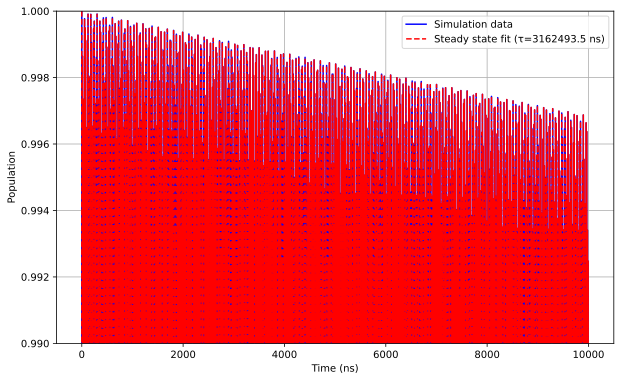

np.float64(3162493.476183027)

In [62]:
# Fit exponential decay to extract relaxation time
from scipy.optimize import curve_fit

def T2fit(t,  T2,omega):
    return np.exp(-t / T2)*np.cos(omega*t)

# Initial guess for parameters
p0 = [15e6, 6.054024194849022]  # occupation and steady_time guess
# Set bounds for parameters: T2 cannot be larger than 1e7
bounds = ([5e4, 6.054024194849022-1e-3], [1e8, 6.054024194849022+1e-3])  # (lower_bounds, upper_bounds)

# Fit the data using first 10000 points
popt, pcov = curve_fit(T2fit, t_list, avg_values[-1], p0=p0,bounds = bounds)
T2_fit = popt[0] 
omega_fit = popt[1]
# print(f"Fitted T2: {T2_fit:.2f} ns")
# print(f"Fitted omega: {omega_fit:.2f} rad/ns")

# Plot the fit
plt.figure(figsize=(10, 6))
plt.plot(t_list, avg_values[-1], 'b-', label='Simulation data')
plt.plot(t_list, T2fit(t_list, *popt), 'r--', label=f'Steady state fit (τ={T2_fit:.1f} ns)')
plt.xlabel('Time (ns)')
plt.ylabel('Population')
plt.ylim(0.99, 1)
plt.legend()
plt.grid(True)
plt.show()

T2_fit

In [66]:
1/T1

np.float64(4.790282910358275e-07)

In [67]:
T2_fit = 3065443

In [68]:
1/T2_fit - 1/T2_fit/2

1.6310856212299494e-07

In [57]:
from hamiltonian_generator import Hamiltonian
import qutip as qt

def get_noise_operator(A):
    phi_ex = 0.2
    Ej = 30.19 
    Ec = 0.1
    
    sc = Hamiltonian(phi_ex, Ej, Ec, [5,4])
    optimal_omega = sc.optimal_omegad(A)[0]*2*np.pi
    sc = Hamiltonian(phi_ex, Ej, Ec, [3,2])
    initial_state, state_and_sigmax, get_projector = sc.setup_floquet_system(A, optimal_omega)
    
    t = 0
    U, _, _ = state_and_sigmax(t)
    Ud = U.T.conj()
    # Work with a fresh copy of noise every time
    noise1 = Ud @ sc.s @ U
    # Take the real part if necessary
    
    return noise1


In [58]:
noise = get_noise_operator(A)

In [41]:
1e-3*np.abs(noise[1,1] - noise[0,0])**2/2 + 1e-3*np.abs(noise[3,1])**2/2 + 1e-3*np.abs(noise[2,0])**2/2/20

np.float64(2.9721862369280763e-38)